In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import math
from sklearn.metrics import mean_squared_error

# BKK

In [2]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[0]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [3]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

,PM2.5,temp,wind speed,wind dir
0,14.0,27.9,16.0,260.0
1,10.0,27.9,16.0,260.0
2,17.0,27.9,16.0,260.0
3,20.0,27.9,16.0,260.0
4,15.0,27.4,16.0,255.0


In [4]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

,Unnamed: 0,date_time,PM2.5,temp,wind speed,wind dir,lat,long
3315,3315,2020-11-16 03:00:00,29.0,26.4,19,50,13.729984,100.536443
5206,5206,2021-02-02 22:00:00,47.0,29.0,24,70,13.729984,100.536443
3989,3989,2020-12-14 05:00:00,43.0,27.4,8,80,13.729984,100.536443
3586,3586,2020-11-27 10:00:00,8.0,28.2,30,70,13.729984,100.536443
8238,8238,2021-06-09 06:00:00,13.0,27.4,48,255,13.729984,100.536443


In [5]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

,date_time,PM2.5,temp,wind speed,wind dir
0,2020-07-01 00:00:00,9.0,29.4,35,270
1,2020-07-01 01:00:00,8.0,29.4,42,260
2,2020-07-01 02:00:00,12.0,28.5,42,260
3,2020-07-01 03:00:00,9.0,28.5,42,260
4,2020-07-01 04:00:00,8.0,28.3,55,270


In [6]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [12]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(26244, 60, 4)

In [15]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 80, activation = 'relu' ,return_sequences = True))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 120, activation = 'relu'))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 12))

In [16]:
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 60)            15600     
                                                                 
 dropout_3 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_4 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_5 (LSTM)               (None, 120)               96480     
                                                                 
 dropout_5 (Dropout)         (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 12)               

In [17]:
#create callback
filepath = province+'_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [18]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [19]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

Epoch 1/10
821/821 [==============================] - 188s 223ms/step - loss: 0.0062 - lr: 0.0010
Epoch 2/10
821/821 [==============================] - 197s 240ms/step - loss: 0.0042 - lr: 0.0010
Epoch 3/10
821/821 [==============================] - 193s 236ms/step - loss: 0.0035 - lr: 0.0010
Epoch 4/10
821/821 [==============================] - 200s 243ms/step - loss: 0.0032 - lr: 0.0010
Epoch 5/10
821/821 [==============================] - 199s 242ms/step - loss: 0.0031 - lr: 0.0010
Epoch 6/10
821/821 [==============================] - 200s 243ms/step - loss: 0.0030 - lr: 0.0010
Epoch 7/10
821/821 [==============================] - 207s 252ms/step - loss: 0.0030 - lr: 0.0010
Epoch 8/10
821/821 [==============================] - 195s 238ms/step - loss: 0.0029 - lr: 0.0010
Epoch 9/10
821/821 [==============================] - 197s 239ms/step - loss: 0.0029 - lr: 0.0010
Epoch 10/10
821/821 [==============================] - 197s 240ms/step - loss: 0.0028 - lr: 0.0010


In [20]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [21]:
past_60_days = data_training.tail(60)

In [22]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

,PM2.5,temp,wind speed,wind dir
0,14.0,31.6,12.0,260.0
1,15.0,33.0,11.0,245.0
2,18.0,33.0,11.0,245.0
3,14.0,33.0,11.0,245.0
4,13.0,32.5,15.0,250.0


In [23]:
df.dropna(inplace=True)
df.shape

(7874, 4)

In [ ]:
df.shape

In [24]:
inputs = scaler.transform(df)
inputs

array([[0.08661417, 0.68899522, 0.14117647, 0.72222222],
       [0.09448819, 0.75598086, 0.12941176, 0.68055556],
       [0.11811024, 0.75598086, 0.12941176, 0.68055556],
       ...,
       [0.08661417, 0.60287081, 0.23529412, 0.69444444],
       [0.08661417, 0.56937799, 0.18823529, 0.68055556],
       [0.08661417, 0.55980861, 0.16470588, 0.65277778]])

In [25]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [26]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((7814, 60, 4), (7814, 12))

In [27]:
y_pred = modelLSTM.predict(X_test)

In [28]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [29]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

BKK RMSE = 2.909682321862461


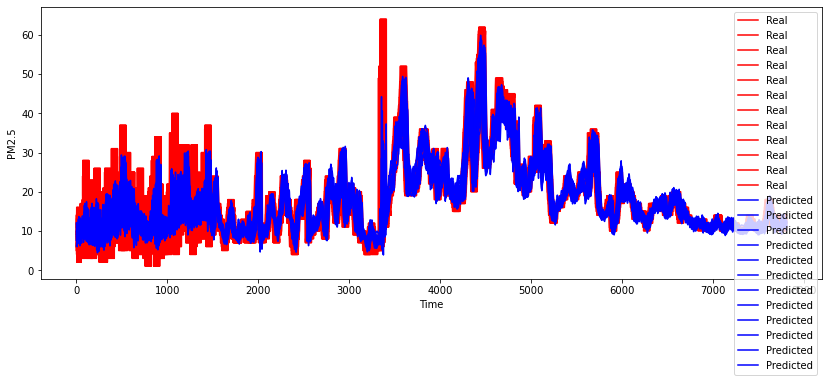

In [30]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [31]:
y_test.shape

(7814, 12)

In [32]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [33]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Chiangmai

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[1]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 80, activation = 'relu'))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 12))

In [ ]:
modelLSTM.summary()

In [ ]:
#create callback
filepath = province+'_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

In [ ]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

In [ ]:
inputs = scaler.transform(df)
inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Khonkaen

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[2]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 100, activation = 'relu', input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 12))

In [ ]:
modelLSTM.summary()

In [ ]:
#create callback
filepath = province+'_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=8, callbacks=callbacks)

In [ ]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
data_test = data_test.drop(['date_time'], axis = 1)
data_test.head()

In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

In [ ]:
inputs = scaler.transform(df)
inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Rayong

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[3]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(LSTM(units = 120, activation = 'relu'))
modelLSTM.add(Dropout(0.2))


modelLSTM.add(Dense(units = 12))

In [ ]:
modelLSTM.summary()

In [ ]:
#create callback
filepath = province+'_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

In [ ]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
data_test.head()

In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

In [ ]:
inputs = scaler.transform(df)
inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Saraburi

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[4]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 120, activation = 'relu',  input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(Dense(units = 12))

In [ ]:
modelLSTM.summary()

In [ ]:
#create callback
filepath = province+'_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

In [ ]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
past_60_days = data_training.tail(60)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

In [ ]:
inputs = scaler.transform(df)
inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Surat

In [ ]:
provinces = ['BKK','Chiangmai','Khonkaen','Rayong','Saraburi','Surat']
province = provinces[5]
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)


In [ ]:
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_training.head()

In [ ]:
data_test = pd.read_csv(province+'_clean.csv', date_parser = True)
data_test.sample(5)

In [ ]:
data_test = data_test.drop(['Unnamed: 0', 'lat', 'long'], axis = 1)
data_test.head()

In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
scaler.inverse_transform(data_training)
scale = 1/scaler.scale_


In [ ]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(data_training[min(i-60+j*6,data_training.shape[0]-1),0])
    y_train.append(a)


X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

In [ ]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 120, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(LSTM(units = 240, activation = 'relu'))
modelLSTM.add(Dropout(0.2))



modelLSTM.add(Dense(units = 12))

In [ ]:
modelLSTM.summary()

In [ ]:
#create callback
filepath = province+'_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

In [ ]:
history = modelLSTM.fit(X_train, y_train, epochs=15, batch_size=64, callbacks=callbacks)

In [ ]:
data_training = pd.read_csv('../'+province+'/train/'+province.lower()+'_train_format.csv', date_parser = True)
data_training = data_training.drop(['date_time', 'lat', 'long'], axis = 1)
data_test = data_test.drop(['date_time'], axis = 1)

In [ ]:
past_60_days = data_training.tail(90)

In [ ]:
df = past_60_days.append(data_test, ignore_index = True)
df.head()

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.shape

In [ ]:
inputs = scaler.transform(df)
inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    a = []
    for j in range(1,13):
        #print(i,j,i-60+j*6)
        a.append(inputs[min(i-60+j*6,inputs.shape[0]-1),0])
    y_test.append(a)

In [ ]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = modelLSTM.predict(X_test)

In [ ]:
scale = 1/scaler.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
print(province+' RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

In [ ]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('lstm_'+province.lower()+'.pickle', 'wb') as fp:
    pickle.dump(y_pred, fp)

In [ ]:
df1 = pd.DataFrame(y_pred)
df1.to_csv('lstm_'+province.lower()+'.csv')

# Submit

In [ ]:
param_dict = {'BKK':[7.0, 70.0, 40.0, 100.0],
'Chiangmai':[7.0, 50.0, 40.0, 100.0],
'Rayong':[2.0, 50.0, 30.0, 40.0],
'Saraburi':[3.0, 50.0, 20.0, 90.0],
'Khonkaen':[1.0, 70.0, 30.0, 90.0],
'Surat':[2.0, 60.0, 20.0, 30.0]}

In [ ]:
ans = pd.DataFrame.from_dict({'Time':[],'Predicted':[],'PM2.5':[],'Province':[]})
for key,value in param_dict.items():
    
    df1 = pd.read_csv(key+'_clean.csv')
    df1.dropna(inplace=True)
    df1.reset_index(inplace=True)
    
    df2 = pd.read_csv('lstm_'+key.lower()+'.csv')
   

    df3 =  pd.DataFrame()
    df3['Predicted']=df1['date_time'].copy()
    df3['PM2.5']=df2['0'].copy()


    df3['Predicted'] = pd.to_datetime(df3['Predicted'])

    submit=pd.read_csv('submit_time_format_2.csv')
    submit['Predicted'] = pd.to_datetime(submit['Predicted'])
    submit['Time'] = pd.to_datetime(submit['Time'])

   
    result = pd.merge(submit, df3, how="left", on=["Predicted"])

    result['Province'] = key

    
    ans = pd.concat([ans,result])

In [ ]:
ans.dropna(inplace=True)
ans.reset_index(inplace=True)
ans['PM2.5'].to_csv('kaggle_lstm.csv')